<a href="https://colab.research.google.com/github/Almee98/COVID-19-Positivity-Rate-Prediction/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

BATCH_SIZE = 4 # batches to load data in
RESIZE_TO = 400 # resize the image for training and transforms

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CLASSES = ['background', 'without_mask', 'with_mask', 'mask_weared_incorrect']
NUM_CLASSES = 4

IMG_DIR = '/content/drive/MyDrive/mask_no_mask_images/images'
XML_DIR = '/content/drive/MyDrive/mask_no_mask_images/annotations'

In [ ]:
# check if cuda (GPU) is available

torch.cuda.is_available()

False

In [ ]:
# Separate dataset into train, validation, and train sets

import os
import random

def train_valid_test_split(img_dir=None, split=0.15):

    # get all the img names
    files = os.listdir(img_dir)

    all_img = files

    # shuffle the list
    random.shuffle(all_img)

    len_imgs = len(all_img)

    # split into train/validation and test sets
    trainTest_split = int((1-split)*len_imgs)

    trainVal_df = all_img[:trainTest_split]
    test_df = all_img[trainTest_split:]

    # further split train/validation set into train and validation sets
    lenTV_df = len(trainVal_df)

    trainVal_split = int((1-split)*lenTV_df)

    train_df = trainVal_df[:trainVal_split]
    valid_df = trainVal_df[trainVal_split:]

    return train_df, valid_df, test_df

train_set, valid_set, test_set = train_valid_test_split(img_dir = IMG_DIR)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=5, p=0.2),
        A.Blur(blur_limit=5, p=0.2),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [ ]:
import cv2
import numpy as np

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well

class Averager:
    """""
    this class keeps track of the training and validation loss values...
    and helps to get the average for each epoch as well
    """""

    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [ ]:
import glob as glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import xml.etree.ElementTree as et

# Creating the dataset class

class maskSet(Dataset):
    def __init__(self, dataset, width, height, classes, img_dir_path, xml_dir_path, transforms=None):
        self.transforms = transforms
        self.img_dir_path = img_dir_path
        self.xml_dir_path = xml_dir_path
        self.height = height
        self.width = width
        self.dataset = dataset
        self.classes = classes

    def __getitem__(self, idx):

        # capture the image name and the full image path
        image_name = self.dataset[idx]
        image_path = os.path.join(self.img_dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)

        # convert BGR to RGB color format and resize
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.xml_dir_path, annot_filename)

        boxes = []
        labels = []

        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # get the height and width of the image
        for i in root.findall('size'):
            image_width = int(i.find('width').text)
            image_height = int(i.find('height').text)

        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))

            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            # make sure bounding box doesn't exceed image dimensions
            if xmin_final > self.width:
                xmin_final = self.width

            if ymin_final > self.height:
                ymin_final = self.height

            if xmax_final > self.width:
                xmax_final = self.width

            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # crowd instances
        if boxes.shape[0] > 1:
            iscrowd = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # label to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']

            target["boxes"] = torch.Tensor(sample['bboxes'])

            return image_resized, target

        else:
            image_resized = np.transpose(image_resized, (2, 0, 1))
            image_resized = torch.from_numpy(image_resized)

            return image_resized, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_dataset = maskSet(train_set, RESIZE_TO, RESIZE_TO, CLASSES, IMG_DIR, XML_DIR)
tran_trainDataset = maskSet(train_set, RESIZE_TO, RESIZE_TO, CLASSES, IMG_DIR, XML_DIR, get_train_transform())
valid_dataset = maskSet(valid_set, RESIZE_TO, RESIZE_TO, CLASSES, IMG_DIR, XML_DIR)

# concat original training data and tranformed data

new_trainSet = ConcatDataset([train_dataset, tran_trainDataset])

# defining train and validation sets data loaders

train_loader = DataLoader(
    new_trainSet,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Number of training samples: {len(new_trainSet)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 1232
Number of validation samples: 109



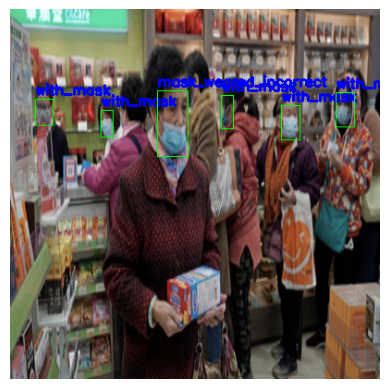

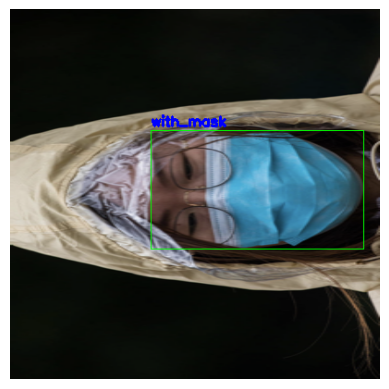

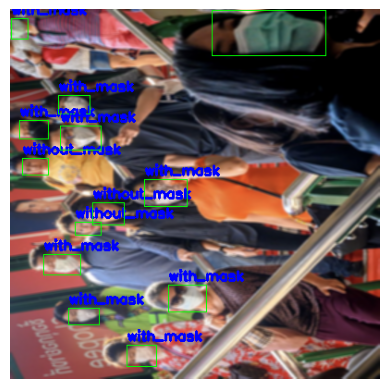

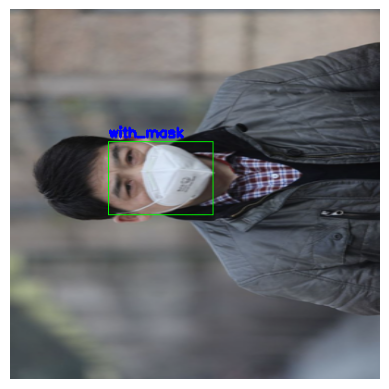

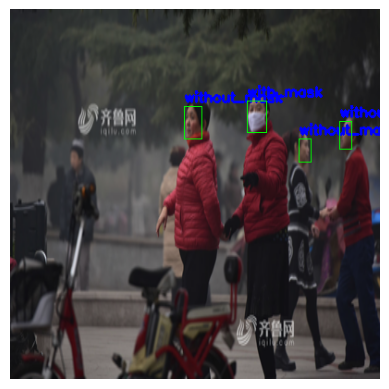

In [ ]:
import matplotlib.pyplot as plt

# function to visualize sample

def visualize_sample(image, target):
    for box, label in zip(target['boxes'], target['labels']):
        label = CLASSES[label]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2
        )

    plt.imshow(image)
    plt.axis('off')
    plt.show()

for i in random.sample(range(len(new_trainSet)), 5):
    image, target = new_trainSet[i]
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    visualize_sample(image, target)

In [ ]:
# defining model

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):

    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# function for running training iterations

def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
# function for running validation iterations

def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
# training the model

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')

SAVE_MODEL_EPOCH = 2 # save model after these many epochs
NUM_EPOCHS = 20 # number of epochs to train for

# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    if (epoch+1) == NUM_EPOCHS: # save model once at the end
        torch.save(model.state_dict(), f"/content/drive/MyDrive/saveepochs{epoch+1}.pth")

    elif (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"/content/drive/MyDrive/saveepochs{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')


EPOCH 1 of 20
Training


  0%|          | 0/308 [00:00<?, ?it/s]